# Understanding Embeddings on Texts

In [1]:
# Based on
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
max_features = 1000  # number of words to consider as features
maxlen = 20  # cut texts after this number of words (among top max_features most common words)

# each review is encoded as a sequence of word indexes
# indexed by overall frequency in the dataset
# output is 0 (negative) or 1 (positive) 
imdb = tf.keras.datasets.imdb.load_data(num_words=max_features)
(raw_input_train, y_train), (raw_input_test, y_test) = imdb

In [6]:
# tf.keras.datasets.imdb.load_data?

In [7]:
y_train.min()

0

In [8]:
y_train.max()

1

In [9]:
# 25000 texts
len(raw_input_train)

25000

In [10]:
# first text has 218 words
len(raw_input_train[0])

218

In [11]:
raw_input_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 2,
 2,
 65,
 458,
 2,
 66,
 2,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 2,
 2,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2,
 19,
 14,
 22,
 4,
 2,
 2,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 2,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2,
 2,
 16,
 480,
 66,
 2,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 2,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 2,
 15,
 256,
 4,
 2,
 7,
 2,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 2,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2,
 56,
 26,
 141,
 6,
 194,
 2,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 2,
 18,
 51,
 36,
 28,
 224,
 92,
 25,
 104,
 4,
 226,
 65,
 16,
 3

In [12]:
# tf.keras.preprocessing.sequence.pad_sequences?

In [12]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

input_train = tf.keras.preprocessing.sequence.pad_sequences(raw_input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(raw_input_test, maxlen=maxlen)

In [13]:
input_train.shape, input_test.shape, y_train.shape, y_test.shape

((25000, 20), (25000, 20), (25000,), (25000,))

In [14]:
# left padded with zeros
# As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.
input_train[0]

array([ 65,  16,  38,   2,  88,  12,  16, 283,   5,  16,   2, 113, 103,
        32,  15,  16,   2,  19, 178,  32])

## We can use a randomly initialized embedding without any training

In [15]:
# tf.keras.layers.Embedding?

In [16]:
embedding_dim = 2

random_model = tf.keras.Sequential()
# Parameters: max_features * embedding_dim 
random_model.add(tf.keras.layers.Embedding(name='embedding',input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

random_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 3)             3000      
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


In [17]:
random_model.predict(input_train[:1])

array([[[0.5936861 , 0.77287316, 0.02072346],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.9561682 , 0.4152248 , 0.49542224],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.05658948, 0.9963356 , 0.6097648 ],
        [0.65952754, 0.34018636, 0.39102137],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.9267534 , 0.8859894 , 0.85122645],
        [0.4188727 , 0.59827256, 0.46787512],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.5868968 , 0.73676896, 0.7879758 ],
        [0.6847576 , 0.721261  , 0.529927  ],
        [0.14753532, 0.04975915, 0.31954753],
        [0.9042752 , 0.6088532 , 0.4106363 ],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.8785337 , 0.4494549 , 0.9322605 ],
        [0.20418513, 0.8619759 , 0.3101083 ],
        [0.14753532, 0.04975915, 0.31954753]]], dtype=float32)

### Training the embedding together with the whole model is more reasonable
Alternative: use a pre-trained model, probably trained using skip-gram

In [19]:
embedding_dim = 2

model = tf.keras.Sequential()
# Parameters: max_features * embedding_dim 
model.add(tf.keras.layers.Embedding(name='embedding', input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

# Output: maxlen * embedding_dim (8)
model.add(tf.keras.layers.Flatten(name='flatten'))

# binary classifier
model.add(tf.keras.layers.Dense(name='fc', units=32, activation='relu'))
model.add(tf.keras.layers.Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 2)             2000      
_________________________________________________________________
flatten (Flatten)            (None, 40)                0         
_________________________________________________________________
fc (Dense)                   (None, 32)                1312      
_________________________________________________________________
classifier (Dense)           (None, 1)                 33        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


In [22]:
batch_size = 128

%time history = model.fit(input_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 82us/step - loss: 0.4736 - acc: 0.7704 - val_loss: 0.5400 - val_acc: 0.7228
Epoch 2/50
20000/20000 [==============================] - 2s 76us/step - loss: 0.4731 - acc: 0.7695 - val_loss: 0.5384 - val_acc: 0.7246
Epoch 3/50
20000/20000 [==============================] - 1s 71us/step - loss: 0.4712 - acc: 0.7715 - val_loss: 0.5399 - val_acc: 0.7228
Epoch 4/50
20000/20000 [==============================] - 1s 75us/step - loss: 0.4695 - acc: 0.7729 - val_loss: 0.5411 - val_acc: 0.7202
Epoch 5/50
20000/20000 [==============================] - 2s 87us/step - loss: 0.4689 - acc: 0.7752 - val_loss: 0.5442 - val_acc: 0.7228
Epoch 6/50
20000/20000 [==============================] - 2s 95us/step - loss: 0.4677 - acc: 0.7733 - val_loss: 0.5438 - val_acc: 0.7228
Epoch 7/50
20000/20000 [==============================] - 1s 70us/step - loss: 0.4668 - acc: 0.7736 - val_loss: 0.5424 - val_acc:

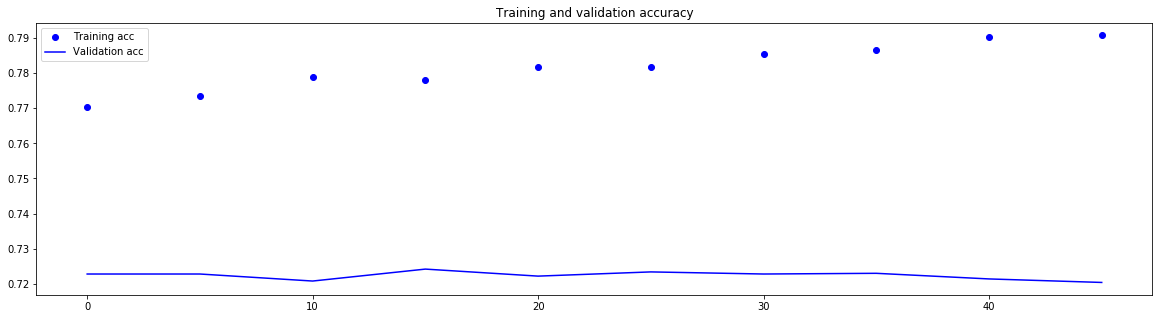

In [36]:
import pandas as pd

def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [23]:
train_loss, train_accuracy = model.evaluate(input_train, y_train, batch_size=batch_size)
train_accuracy

25000/25000 [==============================] - 1s 28us/step


0.780119999961853

In [24]:
test_loss, test_accuracy = model.evaluate(input_test, y_test, batch_size=batch_size)
test_accuracy

25000/25000 [==============================] - 1s 21us/step


0.7199200000190735

In [25]:
# precition
model.predict(input_test[0:5])

array([[0.4178122 ],
       [0.7546584 ],
       [0.08093119],
       [0.6011621 ],
       [0.99955887]], dtype=float32)

In [26]:
# ground truth
y_test[0:5]

array([0, 1, 1, 0, 1], dtype=int64)

### How does the output of the trained embedding look like? 

In [27]:
embedding_layer = model.get_layer('embedding')

In [28]:
model_stub= tf.keras.Model(inputs=model.input, outputs=embedding_layer.output)

In [29]:
embedding_prediction = model_stub.predict(input_test[0:5])

In [30]:
# 5 sample reviews, 500 words per review, 8 dimensions per word
embedding_prediction.shape

(5, 20, 2)

In [31]:
# 8 embedding dimensions of first word of first sample review
embedding_prediction[0][0]

array([0.34398577, 1.2706754 ], dtype=float32)

### Comparing trained to untrained model

In [32]:
input_train[0]

array([ 65,  16,  38,   2,  88,  12,  16, 283,   5,  16,   2, 113, 103,
        32,  15,  16,   2,  19, 178,  32])

In [33]:
model_stub.predict(input_train[:1])

array([[[0.46705735, 0.27016178],
        [0.2602645 , 0.37189814],
        [0.4597462 , 0.4190455 ],
        [0.4966503 , 0.4869977 ],
        [0.2184457 , 0.47358653],
        [0.6243387 , 0.41245297],
        [0.2602645 , 0.37189814],
        [0.5351182 , 0.04236972],
        [0.485593  , 0.19996975],
        [0.2602645 , 0.37189814],
        [0.4966503 , 0.4869977 ],
        [0.6562382 , 0.41497004],
        [0.69112915, 0.5127459 ],
        [0.70034343, 0.52249765],
        [0.67163855, 0.7169122 ],
        [0.2602645 , 0.37189814],
        [0.4966503 , 0.4869977 ],
        [0.6260364 , 0.5533504 ],
        [0.57491267, 0.28364214],
        [0.70034343, 0.52249765]]], dtype=float32)

In [34]:
random_model.predict(input_train[:1])

array([[[0.5936861 , 0.77287316, 0.02072346],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.9561682 , 0.4152248 , 0.49542224],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.05658948, 0.9963356 , 0.6097648 ],
        [0.65952754, 0.34018636, 0.39102137],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.9267534 , 0.8859894 , 0.85122645],
        [0.4188727 , 0.59827256, 0.46787512],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.5868968 , 0.73676896, 0.7879758 ],
        [0.6847576 , 0.721261  , 0.529927  ],
        [0.14753532, 0.04975915, 0.31954753],
        [0.9042752 , 0.6088532 , 0.4106363 ],
        [0.6062163 , 0.07699966, 0.47093225],
        [0.30127788, 0.5647658 , 0.26295507],
        [0.8785337 , 0.4494549 , 0.9322605 ],
        [0.20418513, 0.8619759 , 0.3101083 ],
        [0.14753532, 0.04975915, 0.31954753]]], dtype=float32)